# "2016 Election Day Tweets"

In [ ]:
'''
Features:
-user.favourites_count
-user.statuses_count
-user.created_at
-user.followers_count
-user.friends_count
-favorite_count
-retweet_count

-user.description (text analysis, entity tagging (if there are a lot of organizations could be a predictor))
-text (analysis of the tweet)

-user.verified 
'''

'\nFeatures:\n-user.favourites_count\n-user.statuses_count\n-user.created_at\n-user.followers_count\n-user.friends_count\n-favorite_count\n-retweet_count\n\n-user.description (text analysis, entity tagging (if there are a lot of organizations could be a predictor))\n-text (analysis of the tweet)\n\n-user.verified \n'

**Identifying Verified Users in 2016 Election Day Tweets**

The goal of this project is to evaluate different classification algorithms to identify verified Twitter users in a dataset of 400,000 tweets.

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from textblob import TextBlob
!pip install readability
import readability
import string
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

  Created wheel for readability: filename=readability-0.3.1-cp36-none-any.whl size=35463 sha256=f0de58bb4455958d26c5b8766758d812b7211e18274f9d5e0c08492bba3de8f2
  Stored in directory: /root/.cache/pip/wheels/36/3f/65/bc327f4cdd5bff9ff510834e07522f94389e28858311b33b41
Successfully built readability


Mount the Google Drive and read in the data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/election_day_tweets.csv')

In [ ]:
df.head()

,text,created_at,geo,lang,place,coordinates,user.favourites_count,user.statuses_count,user.description,user.location,user.id,user.created_at,user.verified,user.following,user.url,user.listed_count,user.followers_count,user.default_profile_image,user.utc_offset,user.friends_count,user.default_profile,user.name,user.lang,user.screen_name,user.geo_enabled,user.profile_background_color,user.profile_image_url,user.time_zone,id,favorite_count,retweeted,source,favorited,retweet_count
0,.@Lawrence @HillaryClinton Two first @SenSchu...,2016-11-08 04:04:37,NaN,en,NaN,NaN,18882,26939,"The Specialist, Copyrighted TX0008044160 #Surv...",WorldWide 80Million StealthRUs,22729901,2009-03-04 03:55:45,False,False,https://t.co/rKXNF1G270,374,86551,False,-28800.0,2674,False,Phillip Sheppard,en,PSheppardTV,True,131516,http://pbs.twimg.com/profile_images/7878871945...,America/Los_Angeles,795839414735732737,11,False,Twitter for Android,False,8
1,My @latimesopinion op-ed on historic #Californ...,2016-11-08 04:08:10,NaN,en,NaN,NaN,8,4841,Hoover Institution research fellow; https://t....,"Palo Alto, California",794779346,2012-08-31 22:13:27,False,False,https://t.co/K2fl294qFp,91,1689,False,-28800.0,344,False,Bill Whalen,en,hooverwhalen,True,C0DEED,http://pbs.twimg.com/profile_images/6514470051...,Pacific Time (US & Canada),795840310597193728,3,False,Twitter Web Client,False,4
2,#Senate Wisconsin Senate Preview: Johnson vs. ...,2016-11-08 04:11:35,NaN,en,NaN,NaN,728,160390,US SENATE NEWS FEED. The U.S. Senate is the w...,USA,190890578,2010-09-15 02:41:11,False,False,NaN,798,14726,False,-32400.0,13974,False,Quorum Call,en,QuorumCall,False,473969,http://pbs.twimg.com/profile_images/6155877017...,Alaska,795841168621719552,0,False,dlvr.it,False,0
3,If Rubio Wins and #Trump Loses in #Florida... ...,2016-11-08 04:12:16,NaN,en,NaN,NaN,0,18105,The most trending Marco Rubio news as collecte...,Washington DC,3175968009,2015-04-17 09:59:55,False,False,http://t.co/TbC8SzlTVN,57,121,False,NaN,96,True,Marco Rubio Trends,nl,Rubiolizer,False,C0DEED,http://pbs.twimg.com/profile_images/5890065307...,NaN,795841341146234880,0,False,Lead Stories Feed Publisher,False,0
4,#Senate Wisconsin Senate Preview: Johnson vs. ...,2016-11-08 04:16:20,NaN,en,NaN,NaN,4722,247322,News & #ALERTS. We are a large group of proud ...,24hr Live HD Stream Broadcast,2836839353,2014-10-19 04:50:02,False,False,https://t.co/ceRinWzb9I,288,17479,False,-18000.0,2291,False,NTA✪NEWS ROOM™,en,NoThiefs,False,1B95E0,http://pbs.twimg.com/profile_images/7971276617...,Eastern Time (US & Canada),795842365881782272,0,False,IFTTT,False,0


**Explore the dataset**

In [ ]:
df.columns

Index(['text', 'created_at', 'geo', 'lang', 'place', 'coordinates',
       'user.favourites_count', 'user.statuses_count', 'user.description',
       'user.location', 'user.id', 'user.created_at', 'user.verified',
       'user.following', 'user.url', 'user.listed_count',
       'user.followers_count', 'user.default_profile_image', 'user.utc_offset',
       'user.friends_count', 'user.default_profile', 'user.name', 'user.lang',
       'user.screen_name', 'user.geo_enabled', 'user.profile_background_color',
       'user.profile_image_url', 'user.time_zone', 'id', 'favorite_count',
       'retweeted', 'source', 'favorited', 'retweet_count'],
      dtype='object')

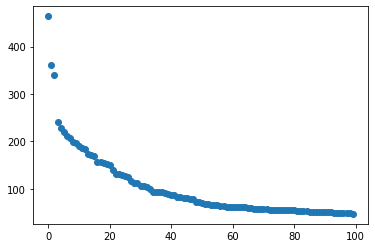

In [ ]:
# Get value counts on the users
counts = df['user.id'].value_counts()[:100]
plt.scatter(np.arange(counts.size), counts)

In [ ]:
mentions_trump = df['text'].apply(lambda x: 'donald' in x.lower() or 'trump' in x.lower())
mentions_hillary = df['text'].apply(lambda x: 'hillary' in x.lower() or 'clinton' in x.lower())

In [ ]:
num_trump_tweets = mentions_trump.sum()
num_clinton_tweets = mentions_hillary.sum()
num_both = (mentions_trump & mentions_hillary).sum()

In [ ]:
print("Total tweets:", df['text'].size)
print("Num tweets mentioning Trump:", num_trump_tweets)
print("Num tweets mentioning Clinton:", num_clinton_tweets)
print("Num tweets mentioning both:", num_both)

Total tweets: 397629
Num tweets mentioning Trump: 64843
Num tweets mentioning Clinton: 42682
Num tweets mentioning both: 17513


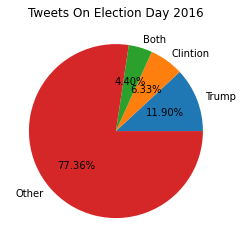

In [ ]:
sizes = [num_trump_tweets - num_both, num_clinton_tweets - num_both, num_both, df['text'].size + num_both - (num_trump_tweets + num_clinton_tweets)]
labels = ["Trump", "Clintion", "Both", "Other"]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%'.format(p=pct)
    return my_autopct

plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
plt.title("Tweets On Election Day 2016")
plt.show()

In [ ]:
# average hashtags per tweet
num_hashtags = df['text'].apply(lambda x: x.count('#'))
print("Average '#' per tweet:", num_hashtags.sum() / num_hashtags.size)
# average @ signs per tweet
num_tags = df['text'].apply(lambda x: x.count('@'))
print("Average number of '@' per tweet:", num_tags.sum()/ num_tags.size)

Average '#' per tweet: 1.3594229797122444
Average number of '@' per tweet: 0.35360348465529423


In [ ]:
# How many verified tweets are there
num_verified_tweets = df['user.verified'].sum()
print("There are", num_verified_tweets, "tweets from verified users in the dataset, which is", "{:.2%}".format(num_verified_tweets/df['user.verified'].size), "of the dataset.")

num_verified_users = df['user.id'][df['user.verified']].value_counts().size
print("These tweets come from", num_verified_users, "different accounts.")
df['user.id'][df['user.verified']].value_counts()

There are 14593 tweets from verified users in the dataset, which is 3.67% of the dataset.
These tweets come from 7845 different accounts.


158070493     62
2312829909    57
39366506      56
3683007026    48
2982269822    42
              ..
16205428       1
2924521080     1
108523129      1
233638131      1
186875904      1
Name: user.id, Length: 7845, dtype: int64

**Create new features from the dataset**

In [ ]:
df['no_punc'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['readability'] = df['no_punc'].apply(lambda x: readability.getmeasures(x, lang='en')['readability grades']['FleschReadingEase'])

# Create polarity and subjectivity columns
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment)
df['polarity'] = df['sentiment'].apply(lambda x: x[0])
df['subjectivity'] = df['sentiment'].apply(lambda x: x[1])

**Create the training and testing data**

In [ ]:
X = df[['user.favourites_count', 'user.statuses_count', 'user.followers_count', 'user.friends_count', 'favorite_count', 'retweet_count', 'readability', 'polarity', 'subjectivity']]
y = df['user.verified']

In [ ]:
X['years_active'] = 2020 - pd.to_datetime(df['user.created_at']).dt.year

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X.columns

Index(['user.favourites_count', 'user.statuses_count', 'user.followers_count',
       'user.friends_count', 'favorite_count', 'retweet_count', 'readability',
       'polarity', 'subjectivity', 'years_active'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

**Testing different models**

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
tree_pred = tree_clf.predict(X_test)
print("Decision Tree Classifier")
print("Precision:", precision_score(y_test, tree_pred))
print("Recall:", recall_score(y_test, tree_pred))

Decision Tree Classifier
Precision: 0.8784722222222222
Recall: 0.2080592105263158


In [ ]:
pd.DataFrame(np.vstack((X_train.columns, tree_clf.feature_importances_)))

,0,1,2,3,4,5,6,7,8,9
0,user.favourites_count,user.statuses_count,user.followers_count,user.friends_count,favorite_count,retweet_count,readability,polarity,subjectivity,years_active
1,0,0,0.859929,0.140071,0,0,0,0,0,0


In [ ]:
random_clf = RandomForestClassifier().fit(X_train, y_train)
random_pred = random_clf.predict(X_test)
print("Random Forest Classifier")
print("Precision:", precision_score(y_test, random_pred))
print("Recall:", recall_score(y_test, random_pred))

Random Forest Classifier
Precision: 0.8441045880611742
Recall: 0.46902412280701755


In [ ]:
pd.DataFrame(np.vstack((X_train.columns, random_clf.feature_importances_)))

,0,1,2,3,4,5,6,7,8,9
0,user.favourites_count,user.statuses_count,user.followers_count,user.friends_count,favorite_count,retweet_count,readability,polarity,subjectivity,years_active
1,0.102196,0.119527,0.327294,0.137366,0.0575709,0.0576723,0.0710261,0.0364576,0.0336894,0.0572014


In [ ]:
neigh_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train)
neigh_pred = neigh_clf.predict(X_test_scaled)
print("K-Neighbors Classifier")
print("Precision", precision_score(y_test, neigh_pred))
print("Recall:", recall_score(y_test, neigh_pred))

K-Neighbors Classifier
Precision 0.7712305025996534
Recall: 0.24396929824561403


In [ ]:
log_clf = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)
log_pred = log_clf.predict(X_test_scaled)
print("Logistic Regression Classifier")
print("Precision", precision_score(y_test, log_pred))
print("Recall:", recall_score(y_test, log_pred))

Logistic Regression Classifier
Precision 0.8552361396303901
Recall: 0.22834429824561403


**More investigation**

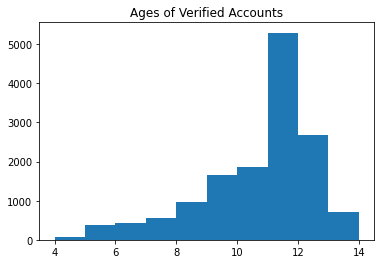

In [ ]:
# Create a histogram of the age of verified accounts
years_active = 2020 - pd.to_datetime(df['user.created_at']).dt.year
plt.hist(years_active[df['user.verified'] == True], 10)
plt.title("Ages of Verified Accounts")
plt.show()

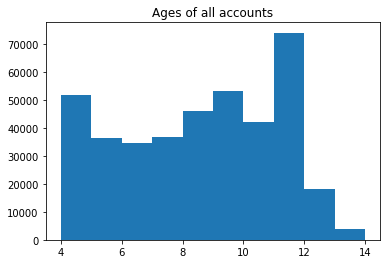

In [ ]:
# Create a histogram of the age of all accounts
plt.hist(years_active, 10)
plt.title("Ages of all accounts")
plt.show()